In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout
from sklearn.preprocessing import StandardScaler
sns.set_style()

In [2]:
data = pd.read_csv('../input/crop-recommendation-dataset/Crop_recommendation.csv')
data.drop(['N', 'P', 'K', 'ph'], axis=1, inplace=True)
data.head()

,temperature,humidity,rainfall,label
0,20.879744,82.002744,202.935536,rice
1,21.770462,80.319644,226.655537,rice
2,23.004459,82.320763,263.964248,rice
3,26.491096,80.158363,242.864034,rice
4,20.130175,81.604873,262.717340,rice


In [3]:
data['label'].unique()[10:] # Second Eleven Label

array(['banana', 'mango', 'grapes', 'watermelon', 'muskmelon', 'apple',
       'orange', 'papaya', 'coconut', 'cotton', 'jute', 'coffee'],
      dtype=object)

## Data Preprocessing

In [4]:
def convert_label(row, label):
    if row['label'] == label:
        row['label'] = 1
    else:
        row['label'] = 0
    return row

def take_200(data, label):
    
    # Data for particular label
    specific_data = data[data['label'] == label]
    
    n = len(specific_data)
    
    # Data for beside particular label
    beside_data = data[data['label'] != label].sample(n)
    
    # Combine specific_data and beside_data
    combined_data = pd.concat([specific_data, beside_data])
    
    # Apply combined_data to convert_label function
    new_data = combined_data.apply(convert_label, label=label, axis=1)
    
    # Reset index and shuffle
    return new_data.sample(frac=1).reset_index(drop=True)

In [5]:
print('First 5 observations of data: \n')
take_200(data, 'rice').head(5)

First 5 observations of data: 



,temperature,humidity,rainfall,label
0,21.865252,80.192301,224.555017,1
1,28.541724,64.202015,69.688623,0
2,27.582589,48.569162,95.844564,0
3,20.045414,80.347756,208.581016,1
4,28.876676,62.490121,182.268818,0


## Model Building (1)

### Hyperparameter Tuning

In [6]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

In [7]:
def create_model(layers, activation):
    model = Sequential()
    for i, neurons in enumerate(layers):
        if i==0:
            model.add(Dense(neurons, input_dim=X_train.shape[1]))
            model.add(Activation(activation))
        else:
            model.add(Dense(neurons))
            model.add(Activation(activation))
    model.add(Dense(1, activation='softmax'))
    
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=create_model, verbose=0)

In [8]:
layers = [[64, 64], [64, 128], [16, 32, 64], [64, 64, 64]]
activations = ['relu', 'tanh']
param_grid = dict(layers=layers, activation=activations, batch_size=[16, 32], epochs=[100])
grid = GridSearchCV(estimator=model, param_grid=param_grid)

In [9]:
# For instance, we choose 100 data containing papaya
papaya_data = take_200(data, 'papaya')
papaya_data.head()

,temperature,humidity,rainfall,label
0,32.863166,91.461887,47.271547,1
1,31.012749,62.403925,63.771924,0
2,29.066315,83.686920,43.951837,0
3,43.080227,93.903057,211.852906,1
4,32.797668,68.779941,64.114111,0


In [10]:
# Define variables
X = papaya_data
y = X.pop('label')

In [11]:
sc = StandardScaler()

In [12]:
from sklearn.model_selection import train_test_split

# Split Training and Testing Dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42)

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

grid_result = grid.fit(X_train, y_train)

[grid_result.best_score_, grid_result.best_params_]

2022-05-31 02:57:22.192493: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-05-31 02:57:22.355370: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


[0.51875,
 {'activation': 'relu', 'batch_size': 16, 'epochs': 100, 'layers': [64, 64]}]

In [13]:
# Build a model structure FOR TUNING
model_tune = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, input_shape=[3], activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    #tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 20))

model_tune.compile(optimizer=tf.keras.optimizers.Adam(), 
             loss='binary_crossentropy',
             metrics=['accuracy'])

history = model_tune.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, callbacks=[lr_schedule])

Epoch 1/100
5/5 [==============================] - 1s 49ms/step - loss: 0.6926 - accuracy: 0.4313 - val_loss: 0.6758 - val_accuracy: 0.6250
Epoch 2/100
5/5 [==============================] - 0s 10ms/step - loss: 0.6925 - accuracy: 0.4313 - val_loss: 0.6758 - val_accuracy: 0.6250
Epoch 3/100
5/5 [==============================] - 0s 11ms/step - loss: 0.6924 - accuracy: 0.4313 - val_loss: 0.6757 - val_accuracy: 0.6250
Epoch 4/100
5/5 [==============================] - 0s 11ms/step - loss: 0.6923 - accuracy: 0.4313 - val_loss: 0.6756 - val_accuracy: 0.6250
Epoch 5/100
5/5 [==============================] - 0s 10ms/step - loss: 0.6922 - accuracy: 0.4375 - val_loss: 0.6754 - val_accuracy: 0.6250
Epoch 6/100
5/5 [==============================] - 0s 10ms/step - loss: 0.6921 - accuracy: 0.4375 - val_loss: 0.6753 - val_accuracy: 0.6250
Epoch 7/100
5/5 [==============================] - 0s 10ms/step - loss: 0.6920 - accuracy: 0.4375 - val_loss: 0.6752 - val_accuracy: 0.6250
Epoch 8/100
5/5 [===

(1e-07, 0.001, 0.0, 10.0)

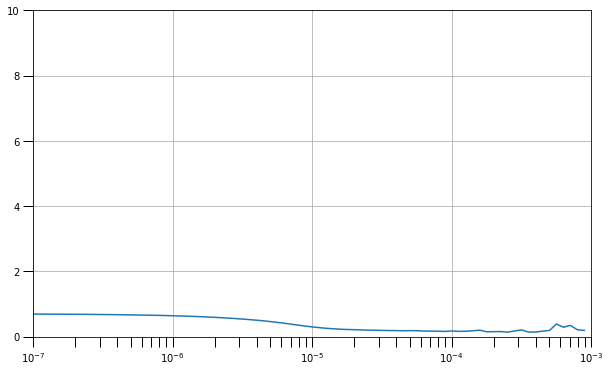

In [14]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-7, 1e-3, 0, 10])

In [15]:
# Build a model structure
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, input_shape=[3], activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    #tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
             loss='binary_crossentropy',
             metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, callbacks=[lr_schedule])

Epoch 1/100
5/5 [==============================] - 1s 49ms/step - loss: 0.7151 - accuracy: 0.4812 - val_loss: 0.6709 - val_accuracy: 0.5750
Epoch 2/100
5/5 [==============================] - 0s 11ms/step - loss: 0.7150 - accuracy: 0.4812 - val_loss: 0.6708 - val_accuracy: 0.5750
Epoch 3/100
5/5 [==============================] - 0s 11ms/step - loss: 0.7149 - accuracy: 0.4812 - val_loss: 0.6707 - val_accuracy: 0.5750
Epoch 4/100
5/5 [==============================] - 0s 11ms/step - loss: 0.7148 - accuracy: 0.4812 - val_loss: 0.6706 - val_accuracy: 0.5750
Epoch 5/100
5/5 [==============================] - 0s 11ms/step - loss: 0.7146 - accuracy: 0.4812 - val_loss: 0.6705 - val_accuracy: 0.5750
Epoch 6/100
5/5 [==============================] - 0s 11ms/step - loss: 0.7145 - accuracy: 0.4812 - val_loss: 0.6704 - val_accuracy: 0.5750
Epoch 7/100
5/5 [==============================] - 0s 14ms/step - loss: 0.7143 - accuracy: 0.4812 - val_loss: 0.6703 - val_accuracy: 0.5750
Epoch 8/100
5/5 [===

In [16]:
second_11_labels = data['label'].unique()[10:]

def new_model(data, labels):
    for label in labels:
        # Initiate data
        crop_data = take_200(data, label)
        
        # Initiate variables
        X = crop_data
        y = X.pop('label')
        
        # Split Training and Testing Dataset
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                            random_state=42)
        
        # Perform Standard Scaling
        X_train = sc.fit_transform(X_train)
        X_test = sc.transform(X_test)
        
        # Initiate a model structure
        model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(64, input_shape=[3], activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            #tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])
        
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
             loss='binary_crossentropy',
             metrics=['accuracy'])
        
        # Fitting the Modek
        history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, verbose=0)
        
        print('{} model => Accuracy: {:.2%} & Validation Accuracy: {:.2%}\n'.format(label.capitalize(), history.history['accuracy'][-1], 
                                                                          history.history['val_accuracy'][-1]))

In [17]:
new_model(data, second_11_labels)

Banana model => Accuracy: 100.00% & Validation Accuracy: 92.50%

Mango model => Accuracy: 99.37% & Validation Accuracy: 97.50%

Grapes model => Accuracy: 100.00% & Validation Accuracy: 100.00%

Watermelon model => Accuracy: 98.12% & Validation Accuracy: 97.50%

Muskmelon model => Accuracy: 100.00% & Validation Accuracy: 100.00%

Apple model => Accuracy: 99.37% & Validation Accuracy: 95.00%

Orange model => Accuracy: 97.50% & Validation Accuracy: 95.00%

Papaya model => Accuracy: 97.50% & Validation Accuracy: 92.50%

Coconut model => Accuracy: 99.37% & Validation Accuracy: 97.50%

Cotton model => Accuracy: 100.00% & Validation Accuracy: 97.50%

Jute model => Accuracy: 100.00% & Validation Accuracy: 90.00%

Coffee model => Accuracy: 99.37% & Validation Accuracy: 100.00%

